
# Lesson 9: Expectation-Maximization (EM) & Gaussian Mixture Models

Key goals:
- Understand latent variables and soft assignments
- Implement E-step and M-step explicitly
- Visualize Gaussian contours + responsibilities
- Track log-likelihood convergence



## Problem Setup

We assume data is generated from a mixture of Gaussians:

\[
p(x) = \sum_{k=1}^K \pi_k \mathcal{N}(x \mid \mu_k, \Sigma_k)
\]

Latent variable:
- \( z_i \in \{1, \dots, K\} \)

EM alternates between:
- **E-step**: compute responsibilities \( \gamma_{ik} = p(z_i=k \mid x_i) \)
- **M-step**: update parameters using soft counts


In [1]:

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)



## Generate 2D Gaussian Mixture Data


In [2]:

# True parameters
n = 300
mu_true = [np.array([-1.5, 0]), np.array([1.5, 0])]
Sigma_true = [np.array([[1, 0.3],[0.3, 1]]),
              np.array([[1, -0.2],[-0.2, 1]])]

X0 = np.random.multivariate_normal(mu_true[0], Sigma_true[0], n//2)
X1 = np.random.multivariate_normal(mu_true[1], Sigma_true[1], n//2)
X = np.vstack([X0, X1])


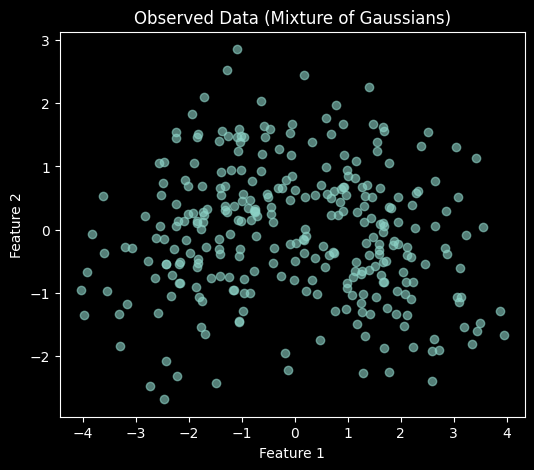

In [3]:

plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], alpha=0.6)
plt.title("Observed Data (Mixture of Gaussians)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()



## Initialize GMM Parameters


In [4]:

K = 2
n, d = X.shape

# Random initialization
mu = X[np.random.choice(n, K, replace=False)]
Sigma = [np.eye(d) for _ in range(K)]
pi = np.ones(K) / K



## Helper: Multivariate Gaussian PDF


In [5]:

def gaussian_pdf(x, mu, Sigma):
    d = len(mu)
    diff = x - mu
    invS = np.linalg.inv(Sigma)
    norm = 1 / np.sqrt((2*np.pi)**d * np.linalg.det(Sigma))
    return norm * np.exp(-0.5 * diff.T @ invS @ diff)



## EM Algorithm


In [6]:

def em_gmm(X, mu, Sigma, pi, epochs=30):
    n, d = X.shape
    K = len(pi)
    log_likelihoods = []

    for _ in range(epochs):
        # E-step
        gamma = np.zeros((n, K))
        for i in range(n):
            for k in range(K):
                gamma[i,k] = pi[k] * gaussian_pdf(X[i], mu[k], Sigma[k])
            gamma[i] /= np.sum(gamma[i])

        # M-step
        Nk = gamma.sum(axis=0)
        for k in range(K):
            mu[k] = np.sum(gamma[:,k][:,None] * X, axis=0) / Nk[k]
            diff = X - mu[k]
            Sigma[k] = (gamma[:,k][:,None,None] * 
                        np.einsum('ni,nj->nij', diff, diff)).sum(axis=0) / Nk[k]
            pi[k] = Nk[k] / n

        # Log-likelihood
        ll = 0
        for i in range(n):
            ll += np.log(sum(pi[k] * gaussian_pdf(X[i], mu[k], Sigma[k]) for k in range(K)))
        log_likelihoods.append(ll)

    return mu, Sigma, pi, gamma, log_likelihoods


In [7]:

mu_hat, Sigma_hat, pi_hat, gamma, ll_hist = em_gmm(X, mu, Sigma, pi)



## Convergence of Log-Likelihood


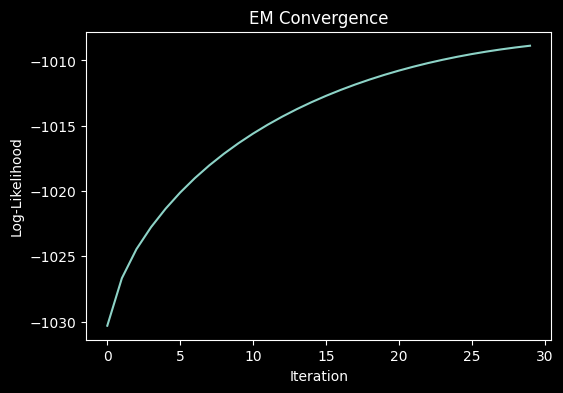

In [8]:

plt.figure(figsize=(6,4))
plt.plot(ll_hist)
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.title("EM Convergence")
plt.show()



## Soft Assignments (Responsibilities)


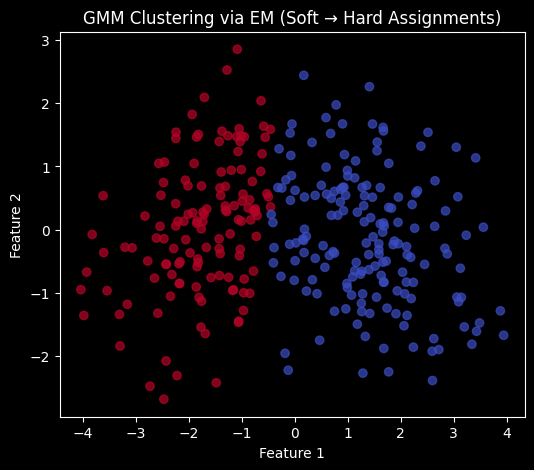

In [9]:

labels_soft = np.argmax(gamma, axis=1)

plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=labels_soft, cmap="coolwarm", alpha=0.7)
plt.title("GMM Clustering via EM (Soft → Hard Assignments)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()



## Gaussian Contours


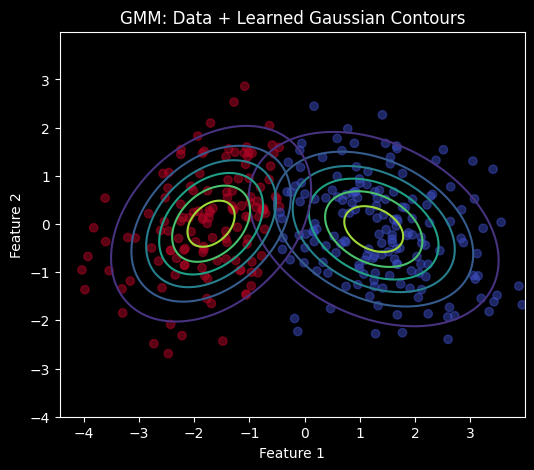

In [10]:

def plot_gaussian_contours(mu, Sigma):
    x, y = np.mgrid[-4:4:.01, -4:4:.01]
    pos = np.dstack((x, y))
    for k in range(len(mu)):
        invS = np.linalg.inv(Sigma[k])
        diff = pos - mu[k]
        Z = np.exp(-0.5 * np.einsum('...i,ij,...j->...', diff, invS, diff))
        plt.contour(x, y, Z, levels=8)

plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=labels_soft, cmap="coolwarm", alpha=0.5)
plot_gaussian_contours(mu_hat, Sigma_hat)
plt.title("GMM: Data + Learned Gaussian Contours")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


## Extended Key Takeaways: Expectation–Maximization & Gaussian Mixture Models

### 1. EM is a general strategy for learning with hidden structure
The core difficulty EM solves is **missing or latent variables**. In Gaussian Mixture Models, the latent variable is *which Gaussian generated each point*. EM turns this hard, discrete assignment into a **soft probabilistic responsibility**, making optimization tractable.

A key insight from CS229 is that:
> EM does not invent new objectives — it optimizes the same likelihood we would want if the latent variables were observable.

---

### 2. Soft assignments are the conceptual leap
Instead of committing each point to a single cluster early, EM assigns **responsibilities**:
\[
\gamma_{ik} = p(z_i = k \mid x_i)
\]

These soft assignments:
- Reduce brittleness compared to hard clustering
- Allow overlapping clusters
- Make parameter updates smoother and more stable

This is why EM often outperforms K-means when clusters overlap or have different shapes.

---

### 3. GMM decision boundaries are non-linear
Even though each Gaussian is a smooth distribution, the **decision boundary between mixture components is generally curved**. This makes GMMs a powerful unsupervised alternative to linear classifiers when data is not linearly separable.

Visually:
- Each component defines an ellipsoidal density
- Classification occurs where posterior probabilities cross
- Boundaries adapt naturally to covariance structure

---

### 4. EM guarantees monotonic improvement — not global optimality
A critical but subtle point:
- EM **guarantees that log-likelihood never decreases**
- EM **does not guarantee convergence to the global maximum**

As a result:
- Initialization matters
- Different runs can converge to different solutions
- Poor initialization can lead to degenerate covariances or collapsed clusters

This is why multiple random restarts are common in practice.

---

### 5. When should you use EM / GMMs?

**Use GMMs when:**
- You believe the data comes from a mixture of continuous distributions
- Clusters overlap
- You want probabilistic cluster membership
- Covariance structure matters (elliptical clusters)

**Avoid GMMs when:**
- Clusters are not Gaussian-like
- Dimensionality is very high relative to sample size (unless regularized)
- You need guaranteed global optima
- Data is categorical or discrete without modification

---

### 6. Relationship to other algorithms
This lesson ties together many earlier ideas:
- **K-means** is a special case of GMMs with equal spherical covariances
- **Naive Bayes** is generative, but supervised and conditional
- **EM** is a framework, not just an algorithm
- Many models (HMMs, topic models, factor analysis) use EM internally

Understanding EM here unlocks a large class of probabilistic models later.

---

### 7. Practical modeling takeaways
From this implementation:
- Log-likelihood is the correct convergence diagnostic
- Responsibilities provide more information than hard labels
- Visualization of contours is essential for sanity checking
- Parameter estimates become meaningful only after convergence

The most important meta-lesson:
> EM is about about learning structure under uncertainty.

This mindset reappears throughout modern machine learning, from probabilistic graphical models to variational autoencoders.
